# Cat and Dog classification

### read data
- dataset -> <https://www.kaggle.com/c/dogs-vs-cats>
- load data from input file
- get training and testing set

In [1]:
import cv2
import os
import glob
import numpy as np

def load_train(train_path, image_size, classes):
    images = []
    labels = []
    img_names = []
    cls = []
    
    print "read training images"
    for fields in classes:
        index = classes.index(fields)
        print "fields {} of {} index".format(fields, index)
        path = os.path.join(train_path, fields, '*g')
        files = glob.glob(path)
        for file in files:
            image = cv2.imread(file)
            # resize
            image = cv2.resize(image, (image_size, image_size), 0, 0, cv2.INTER_LINEAR)
            image = image.astype(np.float32)
            # normalize
            image = np.multiply(image, 1.0/255.0)
            images.append(image)
            # label
            label = np.zeros(len(classes))
            label[index] = 1.0
            labels.append(label)
            img_names.append(os.path.basename(file))
            cls.append(fields)
    images = np.array(images)
    labels = np.array(labels)
    img_names = np.array(img_names)
    cls = np.array(cls)
    
    return images, labels, img_names, cls

In [2]:
from sklearn.utils import shuffle

def read_data_sets(train_path, image_size, classes, validation_size):
    images, labels, img_names, cls = load_train(train_path, image_size, classes)
    images, labels, img_names, cls = shuffle(images, labels, img_names, cls)
    
    validation_size = int(validation_size * images.shape[0])
    
    validation_images = images[:validation_size]
    validation_labels = labels[:validation_size]
    validation_img_names = img_names[:validation_size]
    validation_cls = cls[:validation_size]
    
    train_images = images[validation_size:]
    train_labels = labels[validation_size:]
    train_img_names = img_names[validation_size:]
    train_cls = cls[validation_size:]
    
    train = {
        'images': train_images,
        'labels': train_labels,
        'img_names': train_img_names,
        'cls': train_cls # class
    }
    
    test = {
        'images': validation_images,
        'labels': validation_labels,
        'img_names': validation_img_names,
        'cls': validation_cls
    }
    
    return train, test

In [3]:
#Prepare input data
train_path='data/train'
img_size = 128
classes = ['dogs','cats']
# 20% of the data will automatically be used for validation
validation_size = 0.2

train_set, test_set = read_data_sets(train_path, img_size, classes, validation_size=validation_size)

print "complete to read all training set"
print "got {} training and {} testing".format(len(train_set['labels']), len(test_set['labels']))

read training images
fields dogs of 0 index
fields cats of 1 index
complete to read all training set
got 20000 training and 5000 testing


### train
- use cnn to train

In [4]:
import tensorflow as tf
import time
from datetime import timedelta
import math
import random
import numpy as np

#Adding Seed so that random initialization is consistent
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [5]:
def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def create_biases(size):
    return tf.Variable(tf.constant(0.05, shape=[size]))

In [6]:
def create_convolutional_layer(input, num_input_channels, conv_filter_size, num_filters):
    weights = create_weights(shape=[conv_filter_size, conv_filter_size, num_input_channels, num_filters])
    biases = create_biases(size=num_filters)
    
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
    layer += biases
    
    layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    layer = tf.nn.relu(layer)
    
    return layer

In [7]:
def create_flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer = tf.reshape(layer, [-1, num_features])
    return layer

In [8]:
def create_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)
    
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    
    return layer

In [9]:
session = tf.Session()

# img
num_channels = 3
num_classes = len(classes)
img_size = 128

# placeholder
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

# network graph
filter_size_conv1 = 3
num_filters_conv1 = 32

filter_size_conv2 = 3
num_filters_conv2 = 32

filter_size_conv3 = 3
num_filters_conv3 = 64

fc_layer_size = 128

Instructions for updating:
Use the `axis` argument instead


In [10]:
# cnn layers
layer_conv1 = create_convolutional_layer(input = x, 
                                        num_input_channels = num_channels,
                                        conv_filter_size = filter_size_conv1,
                                        num_filters = num_filters_conv1)

layer_conv2 = create_convolutional_layer(input = layer_conv1, 
                                        num_input_channels = num_filters_conv1,
                                        conv_filter_size = filter_size_conv2,
                                        num_filters = num_filters_conv2)

layer_conv3 = create_convolutional_layer(input = layer_conv2, 
                                        num_input_channels = num_filters_conv2,
                                        conv_filter_size = filter_size_conv3,
                                        num_filters = num_filters_conv3)

# flatten layer
layer_flat = create_flatten_layer(layer_conv3)

# fully connected layer
layer_fc1 = create_fc_layer(input = layer_flat,
                            num_inputs = layer_flat.get_shape()[1:4].num_elements(),
                            num_outputs = fc_layer_size,
                            use_relu = True)

layer_fc2 = create_fc_layer(input = layer_fc1,
                            num_inputs = fc_layer_size,
                            num_outputs = num_classes,
                            use_relu = False)

In [11]:
# prediction
y_pred = tf.nn.softmax(layer_fc2, name='y_pred')
y_pred_cls = tf.argmax(y_pred, dimension=1)

session.run(tf.global_variables_initializer())

In [12]:
# loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = layer_fc2, labels = y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session.run(tf.global_variables_initializer())

In [19]:
import random

def train(train_set, test_set, epochs=10, iteration=100, batch_size=32):
    saver = tf.train.Saver()
    saver.restore(session, 'dogs-cats-model')
    numOfTrainSet = len(train_set['labels'])
    numOfTestSet = len(test_set['labels'])
    for i in range(epochs):
        for j in range(iteration):
            # train
            trainRangeBase = random.randint(0, numOfTrainSet-batch_size-1)
            train_x_batch = train_set['images'][trainRangeBase:trainRangeBase+batch_size]
            train_y_true_batch = train_set['labels'][trainRangeBase:trainRangeBase+batch_size]
            train_cls_batch = train_set['cls'][trainRangeBase:trainRangeBase+batch_size]
            # feed
            feed_dict_tr = {
                x: train_x_batch,
                y_true: train_y_true_batch
            }
            session.run(optimizer, feed_dict=feed_dict_tr)
            train_loss = session.run(cost, feed_dict=feed_dict_tr)
            train_acc = session.run(accuracy, feed_dict=feed_dict_tr)
            
            print "{} epochs, {}/{} iter, {} loss, {} accuracy".format(i, j, iteration, train_loss, train_acc)
            
        # test
        testRangeBase = random.randint(0, numOfTestSet-batch_size-1)
        test_x_batch = test_set['images'][testRangeBase:testRangeBase+batch_size]
        test_y_true_batch = test_set['labels'][testRangeBase:testRangeBase+batch_size]
        test_cls_batch = test_set['cls'][testRangeBase:testRangeBase+batch_size]
        
        feed_dict_val = {
                x: test_x_batch,
                y_true: test_y_true_batch
        }    
        test_loss = session.run(cost, feed_dict=feed_dict_val)
        test_acc = session.run(accuracy, feed_dict=feed_dict_val)
        print ":: end -> {} epochs, {} loss, {} accuracy".format(i, test_loss, test_acc)
        if test_acc > 0.95:
            print "model saved as dogs-cats-model"
            saver.save(session, 'dogs-cats-model')
            break

    print "model saved as dogs-cats-model"
    saver.save(session, 'dogs-cats-model')

In [20]:
train(train_set, test_set, epochs=200, iteration=100, batch_size=64)

0 epochs, 0/100 iter, 0.0808703154325 loss, 1.0 accuracy
0 epochs, 1/100 iter, 0.188510149717 loss, 0.9375 accuracy
0 epochs, 2/100 iter, 0.337198495865 loss, 0.84375 accuracy
0 epochs, 3/100 iter, 0.152101993561 loss, 0.921875 accuracy
0 epochs, 4/100 iter, 0.166907161474 loss, 0.9375 accuracy
0 epochs, 5/100 iter, 0.252776503563 loss, 0.90625 accuracy
0 epochs, 6/100 iter, 0.0687507838011 loss, 0.984375 accuracy
0 epochs, 7/100 iter, 0.258173108101 loss, 0.875 accuracy
0 epochs, 8/100 iter, 0.152095124125 loss, 0.96875 accuracy
0 epochs, 9/100 iter, 0.157679393888 loss, 0.9375 accuracy
0 epochs, 10/100 iter, 0.0852563306689 loss, 0.984375 accuracy
0 epochs, 11/100 iter, 0.130641624331 loss, 0.953125 accuracy
0 epochs, 12/100 iter, 0.0699602216482 loss, 1.0 accuracy
0 epochs, 13/100 iter, 0.13784134388 loss, 0.984375 accuracy
0 epochs, 14/100 iter, 0.286159366369 loss, 0.875 accuracy
0 epochs, 15/100 iter, 0.149262502789 loss, 0.953125 accuracy
0 epochs, 16/100 iter, 0.273862361908 lo

1 epochs, 34/100 iter, 0.117166355252 loss, 0.953125 accuracy
1 epochs, 35/100 iter, 0.193400889635 loss, 0.921875 accuracy
1 epochs, 36/100 iter, 0.0738478302956 loss, 0.984375 accuracy
1 epochs, 37/100 iter, 0.0698912590742 loss, 0.984375 accuracy
1 epochs, 38/100 iter, 0.229400634766 loss, 0.90625 accuracy
1 epochs, 39/100 iter, 0.066891849041 loss, 0.984375 accuracy
1 epochs, 40/100 iter, 0.14684933424 loss, 0.96875 accuracy
1 epochs, 41/100 iter, 0.235336720943 loss, 0.90625 accuracy
1 epochs, 42/100 iter, 0.0667837783694 loss, 1.0 accuracy
1 epochs, 43/100 iter, 0.184896528721 loss, 0.890625 accuracy
1 epochs, 44/100 iter, 0.0958173200488 loss, 0.984375 accuracy
1 epochs, 45/100 iter, 0.145451888442 loss, 0.90625 accuracy
1 epochs, 46/100 iter, 0.117884591222 loss, 0.96875 accuracy
1 epochs, 47/100 iter, 0.0767275691032 loss, 1.0 accuracy
1 epochs, 48/100 iter, 0.173114687204 loss, 0.921875 accuracy
1 epochs, 49/100 iter, 0.177375793457 loss, 0.953125 accuracy
1 epochs, 50/100 it

2 epochs, 67/100 iter, 0.0746978521347 loss, 0.984375 accuracy
2 epochs, 68/100 iter, 0.253910064697 loss, 0.875 accuracy
2 epochs, 69/100 iter, 0.100437507033 loss, 0.984375 accuracy
2 epochs, 70/100 iter, 0.168136924505 loss, 0.953125 accuracy
2 epochs, 71/100 iter, 0.0779113471508 loss, 1.0 accuracy
2 epochs, 72/100 iter, 0.145978182554 loss, 0.96875 accuracy
2 epochs, 73/100 iter, 0.229271382093 loss, 0.890625 accuracy
2 epochs, 74/100 iter, 0.102324388921 loss, 0.984375 accuracy
2 epochs, 75/100 iter, 0.26296454668 loss, 0.90625 accuracy
2 epochs, 76/100 iter, 0.0785274431109 loss, 1.0 accuracy
2 epochs, 77/100 iter, 0.0992204621434 loss, 0.984375 accuracy
2 epochs, 78/100 iter, 0.0597778968513 loss, 0.984375 accuracy
2 epochs, 79/100 iter, 0.101239725947 loss, 0.953125 accuracy
2 epochs, 80/100 iter, 0.0912513583899 loss, 0.96875 accuracy
2 epochs, 81/100 iter, 0.127714514732 loss, 0.96875 accuracy
2 epochs, 82/100 iter, 0.0356258824468 loss, 1.0 accuracy
2 epochs, 83/100 iter, 0

4 epochs, 0/100 iter, 0.205098375678 loss, 0.875 accuracy
4 epochs, 1/100 iter, 0.0793825760484 loss, 0.984375 accuracy
4 epochs, 2/100 iter, 0.100793227553 loss, 0.953125 accuracy


KeyboardInterrupt: 

### predict
- make a prediction

In [11]:
import tensorflow as tf

session = tf.Session()
saver = tf.train.import_meta_graph('dogs-cats-model.meta')
saver.restore(session, tf.train.latest_checkpoint('./'))
graph = tf.get_default_graph()

y_pred = graph.get_tensor_by_name("y_pred:0")
x = graph.get_tensor_by_name("x:0")
y_true = graph.get_tensor_by_name("y_true:0")

INFO:tensorflow:Restoring parameters from ./dogs-cats-model


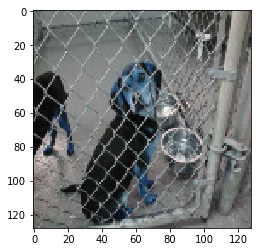

dog: 0.00335106998682, cat: 0.996648967266


In [34]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import os
import glob
import numpy as np
import random

image_size = 128
num_channels = 3
images = []
test_path = 'data/test'
path = os.path.join(test_path, '*g')
files = glob.glob(path)

image = cv2.imread(files[random.randint(0, len(files))])
# resize
image = cv2.resize(image, (image_size, image_size), 0, 0, cv2.INTER_LINEAR)
images.append(image)
plt.imshow(image)
plt.show()

images = np.array(images, dtype=np.uint8)
images = images.astype('float32')
images = np.multiply(images, 1.0/255.0)

x_batch = images.reshape(1, image_size, image_size, num_channels)    
y_test_images = np.zeros((1, 2))

feed_dict_testing = {x: x_batch, y_true: y_test_images}
result = session.run(y_pred, feed_dict=feed_dict_testing)
print "dog: {}, cat: {}".format(result[0][0], result[0][1])

### show conv3 as image

INFO:tensorflow:Restoring parameters from dogs-cats-model
(128, 128, 3)


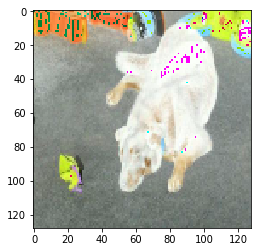

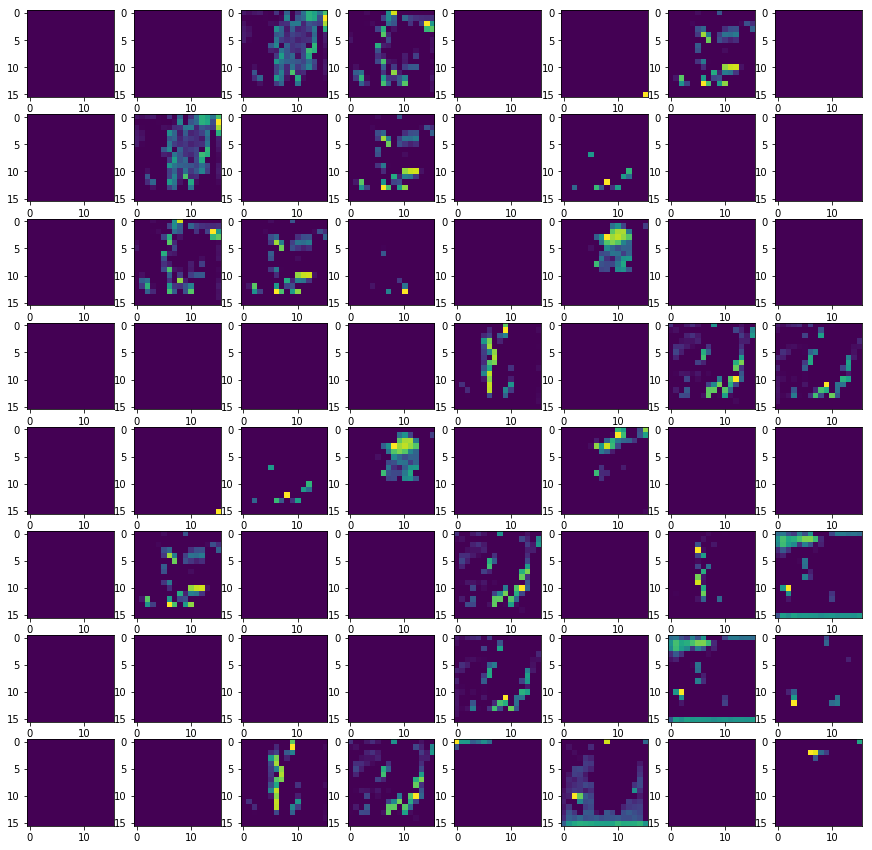

In [83]:
from matplotlib import pyplot as plt
%matplotlib inline
saver = tf.train.Saver()
saver.restore(session, 'dogs-cats-model')
train_x_batch = train_set['images'][0:3]
train_y_true_batch = train_set['labels'][0:3]
train_cls_batch = train_set['cls'][0:3]
# feed
feed_dict_tr = {
    x: train_x_batch,
    y_true: train_y_true_batch
}
cn3v = session.run(layer_conv3, feed_dict=feed_dict_tr)
idx = 2
src = np.multiply(train_x_batch[idx], 255.0)
plt.imshow(src, interpolation='nearest')
print src.shape
f, ax = plt.subplots(8,8,figsize=(15,15))
for i in range(0,8):
    for j in range(0,8):
        ax[i][j].imshow(cn3v[idx,:,:,(i+1)*j-1], interpolation='nearest')